# enable user scoped libraries

In [1]:
import site
site.addsitedir(site.USER_SITE)

# import basic packages

In [2]:
import math
import numpy as np
import torch

# params

In [3]:
BATCH_SIZE=128
EPOCHS = 30
VALIDATION_RATIO = 0.2
RANDOM_SEED = 1

# function to preprocess datasets

In [4]:
from torchvision import transforms

In [5]:
preprocess = transforms.Compose([
    transforms.ToTensor()
])

# load training datasets

In [6]:
from torchvision import datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [7]:
mnist = datasets.MNIST('../data', download=True, transform=preprocess)
dataset_shape  = mnist.train_data.size()
dataset_shape 

torch.Size([60000, 28, 28])

# train validation split

In [8]:
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data.sampler import SubsetRandomSampler

In [9]:
sample_count = dataset_shape[0]
validation_count = math.floor(VALIDATION_RATIO * sample_count)
train_count = sample_count - validation_count

In [10]:
tset, vset = random_split(mnist, [train_count, validation_count])

In [11]:
trainingset = DataLoader(tset, batch_size=BATCH_SIZE, shuffle=True)
validationset = DataLoader(vset, batch_size=len(vset))

### content of the first image

In [12]:
data, label = trainingset.dataset[0]

In [13]:
data[0]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

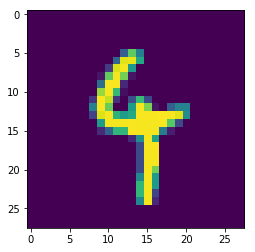

In [14]:
plt.imshow(data[0].numpy())

### label of the first image

In [15]:
label

tensor(4)

# definition of network

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class FeedForwardNetwork(nn.Module):
    
    def __init__(self, data_size, out_size):
        super(FeedForwardNetwork, self).__init__()
        
        self.data_dim = self._num_flat_features(data_size)
        
        self.in_layer = nn.Linear(in_features=self.data_dim, out_features=128)
        self.in_dropout = nn.Dropout(p=0.2)
        self.in_normalize = nn.BatchNorm1d(num_features=128, affine=True)
        self.in_activate = nn.ReLU()
        
        self.hidden1_layer = nn.Linear(in_features=128, out_features=128)
        self.hidden1_dropout = nn.Dropout(p=0.2)
        self.hidden1_normalize = nn.BatchNorm1d(num_features=128, affine=True)
        self.hidden1_activate = nn.ReLU()
        
        self.hidden2_layer = nn.Linear(in_features=128, out_features=128)
        self.hidden2_dropout = nn.Dropout(p=0.2)
        self.hidden2_normalize = nn.BatchNorm1d(num_features=128, affine=True)
        self.hidden2_activate = nn.ReLU()
        
        self.out_layer = nn.Linear(in_features=128, out_features=out_size)
        self.out_normalize = nn.BatchNorm1d(num_features=10, affine=True)
        
    def forward(self, x):
        x = torch.reshape(x, (x.size(0), self.data_dim))
        
        # input layer
        x = self.in_activate(self.in_normalize(self.in_dropout(self.in_layer(x))))
        
        # hidden layers
        x = self.hidden1_activate(self.hidden1_normalize(self.hidden1_dropout(self.hidden1_layer(x))))
        x = self.hidden2_activate(self.hidden2_normalize(self.hidden2_dropout(self.hidden2_layer(x))))
        
        # output layer
        x = F.softmax(self.out_normalize(self.out_layer(x)), dim=1) 
        return x
        
    def _num_flat_features(self, size):
        num = 1
        for dim in size[1:]:
            num *= dim
        return num

network = FeedForwardNetwork(data_size=dataset_shape, out_size=10)

In [18]:
network

FeedForwardNetwork(
  (in_layer): Linear(in_features=784, out_features=128, bias=True)
  (in_dropout): Dropout(p=0.2)
  (in_normalize): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (in_activate): ReLU()
  (hidden1_layer): Linear(in_features=128, out_features=128, bias=True)
  (hidden1_dropout): Dropout(p=0.2)
  (hidden1_normalize): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden1_activate): ReLU()
  (hidden2_layer): Linear(in_features=128, out_features=128, bias=True)
  (hidden2_dropout): Dropout(p=0.2)
  (hidden2_normalize): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden2_activate): ReLU()
  (out_layer): Linear(in_features=128, out_features=10, bias=True)
  (out_normalize): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

# training

In [19]:
import torch.optim as optim

In [20]:
loss_fn = F.cross_entropy
optimizer = optim.Adam(network.parameters(), lr=0.01, betas=[0.9, 0.999])

In [21]:
training_losses = []
validation_losses = []

for epoch in range(EPOCHS):
    for data in trainingset:
        x, t = data

        optimizer.zero_grad()
        y = network(x)
        
        training_loss = loss_fn(y, t)
        training_loss.backward()
        optimizer.step()
    
    training_losses.append(training_loss.item())
    
    for data in validationset:
        x, t = data
        y = network(x)
        
        validation_loss = loss_fn(y, t)
        validation_losses.append(validation_loss.item())
    
    print('epoch: {0}/{1}, training_loss: {2}, validation_loss: {3}'.format(epoch + 1, EPOCHS, training_loss.item(), validation_loss.item()))

epoch: 1/30, training_loss: 1.5767312049865723, validation_loss: 1.534272313117981
epoch: 2/30, training_loss: 1.5192404985427856, validation_loss: 1.519007682800293
epoch: 3/30, training_loss: 1.4895987510681152, validation_loss: 1.5061911344528198
epoch: 4/30, training_loss: 1.5002930164337158, validation_loss: 1.502048373222351
epoch: 5/30, training_loss: 1.49653959274292, validation_loss: 1.5021532773971558
epoch: 6/30, training_loss: 1.4830952882766724, validation_loss: 1.4969806671142578
epoch: 7/30, training_loss: 1.5055198669433594, validation_loss: 1.4989650249481201
epoch: 8/30, training_loss: 1.4886049032211304, validation_loss: 1.4999216794967651
epoch: 9/30, training_loss: 1.4993969202041626, validation_loss: 1.4964265823364258
epoch: 10/30, training_loss: 1.5231953859329224, validation_loss: 1.494498372077942
epoch: 11/30, training_loss: 1.489976167678833, validation_loss: 1.492887258529663
epoch: 12/30, training_loss: 1.475942850112915, validation_loss: 1.493309855461120

# loss transition

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

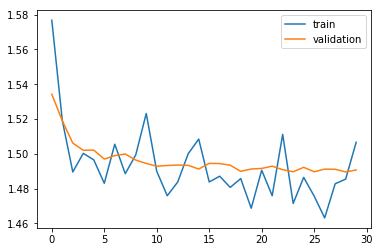

In [23]:
x_axis = np.arange(EPOCHS)
plt.plot(x_axis, training_losses, label='train')
plt.plot(x_axis, validation_losses, label='validation')
plt.legend()
plt.show()

# evaluation

In [24]:
test_mnist =  datasets.MNIST('../data', download=True, transform=preprocess, train=False)
test_mnist.test_data.size()

torch.Size([10000, 28, 28])

In [25]:
testset = test_mnist.test_data.type(torch.FloatTensor)
test_labels = test_mnist.test_labels

In [26]:
y = network(testset)

## logloss

In [27]:
logloss = loss_fn(y, test_labels)
logloss.item()

1.4918360710144043

## accuracy

In [28]:
y_labels = torch.argmax(y, dim=1)

In [29]:
correct_count = torch.sum(y_labels == test_labels, dim=0).item()

In [30]:
accuracy = correct_count / len(y_labels)
accuracy

0.97